In [1]:
#We import the necessary libraries.
%matplotlib inline

In [2]:
import os

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize
from importlib import reload

In [4]:
import corner

In [5]:
import radvel

In [6]:
#To obtain the Light Curve Data we search the MAST Database using lightkurve library.
import lightkurve as lk

In [7]:
#We get the Light Curve Data of K2-260.
#Note that the exposure time should be in seconds.
target = "K2-260"
data_search = lk.search_lightcurve(target, exptime = 1800)

data_search

SearchResult containing 10 data products.

 #     mission     year       author      exptime  target_name  distance
                                             s                   arcsec 
--- -------------- ---- ----------------- ------- ------------- --------
  0 K2 Campaign 13 2017                K2    1800 ktwo246911830      0.0
  1 K2 Campaign 13 2017           EVEREST    1800 ktwo246911830      0.0
  2 K2 Campaign 13 2017             K2SFF    1800 ktwo246911830      0.0
  3 TESS Sector 05 2018               QLP    1800     293612446      0.0
  4 TESS Sector 05 2018 GSFC-ELEANOR-LITE    1800     293612446      0.0
  5 TESS Sector 05 2018             TASOC    1800     293612446      0.0
  6 TESS Sector 05 2018             TASOC    1800     293612446      0.0
  7 TESS Sector 05 2018              TGLC    1800     293612446      0.0
  8 TESS Sector 32 2020             CDIPS    1800     293612446      0.0
  9 TESS Sector 43 2021             CDIPS    1800     293612446      0.0

In [8]:
#We select the Light Curve Data.
selected_lc_data = data_search[0]

selected_lc_data

SearchResult containing 1 data products.

 #     mission     year author exptime  target_name  distance
                                  s                   arcsec 
--- -------------- ---- ------ ------- ------------- --------
  0 K2 Campaign 13 2017     K2    1800 ktwo246911830      0.0

In [9]:
#We download that Light Curve Data as follows.
lc_data = selected_lc_data.download()

lc_data

<KeplerLightCurve length=3643 LABEL="EPIC 246911830" CAMPAIGN=13 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
       time             flux      ...   pos_corr1      pos_corr2   
                    electron / s  ...      pix            pix      
       Time           float32     ...    float32        float32    
------------------ -------------- ... -------------- --------------
 2987.581662275392            ——— ... -1.3924639e-02 -1.8543383e-01
2987.6020948019286  1.2447252e+05 ... -5.8377776e-02 -1.6549455e-01
 2987.622527127991  1.2447829e+05 ... -1.0489360e-01 -1.4414588e-01
  2987.64295955313  1.2449541e+05 ... -1.5130405e-01 -1.2268101e-01
2987.6633920782697  1.2375815e+05 ... -1.9845515e-01 -1.0368166e-01
2987.6838244020037  1.2335721e+05 ... -2.4166067e-01 -8.5811257e-02
2987.7042568257457  1.2329288e+05 ... -2.8271979e-01 -7.2331764e-02
 2987.724689348557  1.2325332e+05 ... -3.3038658e-01 -5.5974748e-02
 2987.745121670894  1.2324495e+05 ... -3.8032132e-01 -3.6034405e-02
               ...            ... ...            ...            ...
  3067.98078546179  1.2446935e+05 ... -3.9608949e-01  8.6664461e-02
 3068.001217233599  1.2446587e+05 ... -4.3921834e-01  1.0247342e-01
 3068.021649105649  1.2444342e+05 ... -4.9821353e-01  1.2279789e-01
3068.0420807780465  1.2441727e+05 ... -5.4616421e-01  1.4072303e-01
 3068.062512550787  1.2437723e+05 ... -6.0607320e-01  1.6226965e-01
 3068.082944423768  1.2436430e+05 ... -6.6640890e-01  1.8409219e-01
3068.1033760969804  1.2435164e+05 ... -7.1938854e-01  2.0300311e-01
3068.1238077705348  1.2429798e+05 ... -7.8454167e-01  2.2946973e-01
 3068.144239644447  1.2431729e+05 ... -8.2339692e-01  2.4647711e-01

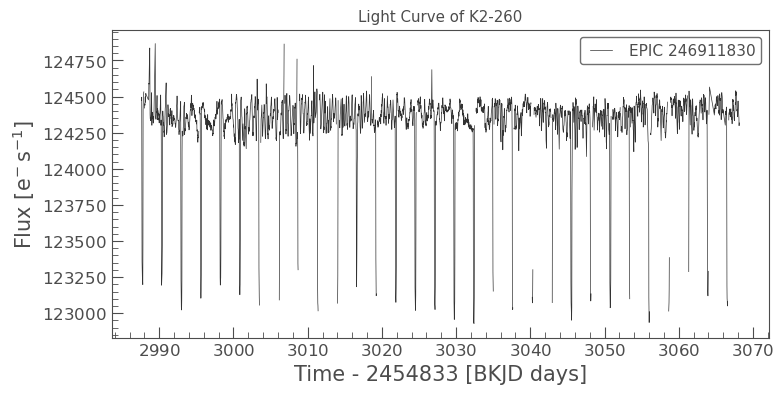

In [10]:
#Then we can plot the Light Curve Data as follows.
lc_data.plot()
plt.title(f"Light Curve of {target}")
plt.show()

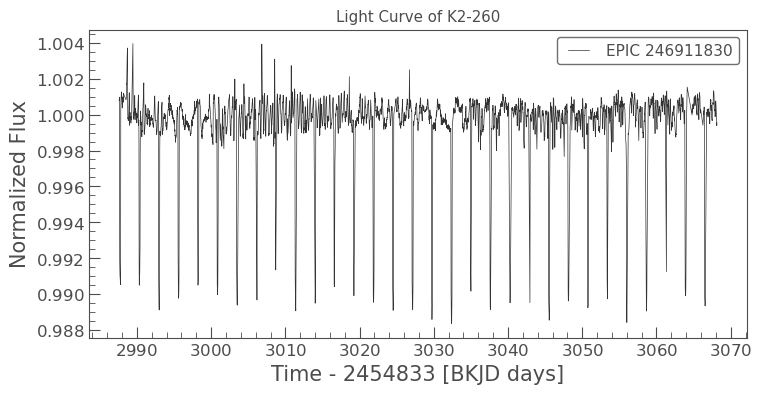

In [11]:
#We remove "Not a Number (NaN) values, then normalize the Fluxes to 1 as follows"
lc = lc_data[lc_data.flux.value > 0].remove_nans().normalize()

#Then our Light Curve becomes the following.
lc.plot()
plt.title(f"Light Curve of {target}")
plt.show()

In [12]:
###### We then define raw datas of time, flux and flux error as arrays.
t = lc.time.value
flux = lc.flux.value
flux_err = lc.flux_err.value

#We mask out the values depending on the quality value.
quality = lc.quality.value
mask = quality == 0

In [13]:
#Then we create a dataframe with the masked values.
df = pd.DataFrame()
df["time"] = t[mask]
df["flux"] = flux[mask]
df["flux_err"] = flux_err[mask]

df

time      flux  flux_err
0     2989.257120  0.999720  0.000084
1     2989.277552  0.999975  0.000084
2     2989.297984  1.000200  0.000084
3     2989.318417  1.000755  0.000084
4     2989.338849  1.001147  0.000083
...           ...       ...       ...
3172  3068.021649  1.000551  0.000086
3173  3068.042081  1.000340  0.000086
3174  3068.062513  1.000018  0.000086
3175  3068.082944  0.999914  0.000085
3176  3068.123808  0.999381  0.000085

[3177 rows x 3 columns]

In [14]:
#From here we can get the time, flux and flux error as arrays.
t = df.time.values
flux = df.flux.values
flux_err = df.flux_err.values.filled(np.nan)

In [15]:
#Now we import the GaiaRV source codes.
import sys
sys.path.insert(0, '../../gaiafit/')
try:
    sys.path.remove('\\wsl.localhost\\Ubuntu\\home\\kayahan')
except Exception as e:
    print(e)

#We import utils.py, gaiafit.py, gaiasource.py as follows.
import utils
import gaiafitwithtransit
import gaiasource
reload(gaiafitwithtransit)

gaiafitwithtransit, gaiasource, utils

list.remove(x): x not in list


(<module 'gaiafitwithtransit' from '/home/kayahan/ExoSoft/notebooks/lc-tests/../../gaiafit/gaiafitwithtransit.py'>,
 <module 'gaiasource' from '/home/kayahan/ExoSoft/notebooks/lc-tests/../../gaiafit/gaiasource.py'>,
 <module 'utils' from '/home/kayahan/ExoSoft/notebooks/lc-tests/../../gaiafit/utils.py'>)

In [16]:
#We load the Prior file for our target.
f = '../../data/lcpriors/K2-260_prior.txt'
reload(gaiafitwithtransit)

<module 'gaiafitwithtransit' from '/home/kayahan/ExoSoft/notebooks/lc-tests/../../gaiafit/gaiafitwithtransit.py'>

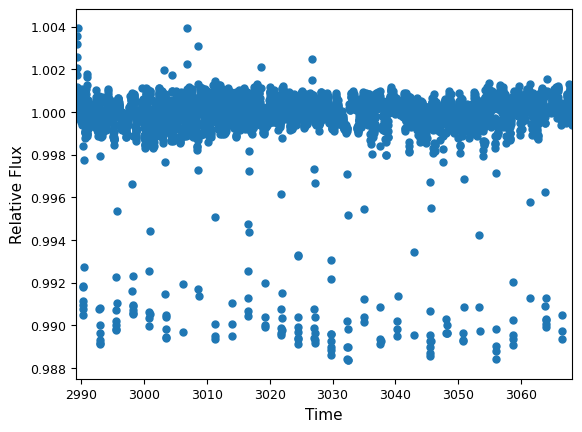

In [17]:
# #Now that we have the priors, we can take the T0 and P value from the prior file to check how the light curve looks.
# #First we read our Prior file.
# prior_file = pd.read_csv(f, delim_whitespace=True, header=None, comment="#", names=["parameter", "distribution", "value"])

# #We extract the T0 and P values from the file.
# #Note that due to how the prior file is set, we need to use "," to split the values and take the first one, which is
# #the parameter value.
# T0 = float(prior_file[prior_file["parameter"] == "P_p1"]["value"].values[0].split(",")[0])
# P = float(prior_file[prior_file["parameter"] == "t0_p1"]["value"].values[0].split(",")[0])

# #From here, we can calculate the phase as follows.
# phase = ((t - T0) % P) / P
# #phase = ((t-T0 + 0.5*P) % P)/P

#Now we plot the Phase-Folded Light Curve.
#Note that we need to convert "MaskedNDArray" type into regular numpy arrays when it comes to plotting the errorbar.
#That's why, we use .filled(np.nan) for the "flux_err" Masked N-Dimension Array (MaskedNDArray).
plt.errorbar(t, flux, flux_err, fmt="o")
plt.xlabel("Time", fontsize=11)
plt.ylabel("Relative Flux", fontsize=11)

#To see the transit more clear for this target, we limit x i.e. the time to maximum and minimum time value we have.
plt.xlim(min(t),max(t))
plt.show()

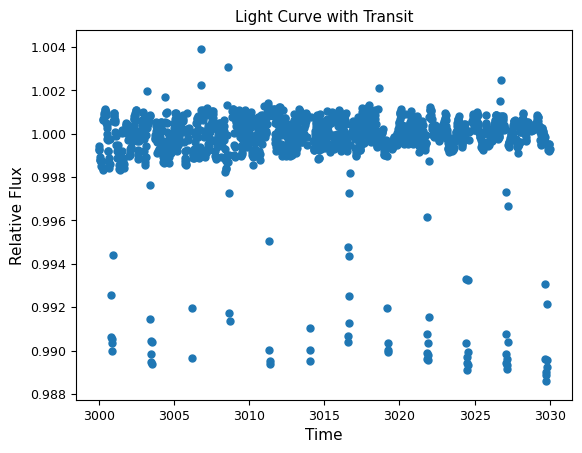

In [18]:
#We create a mask to remove the parts where there is no transit.
mask = (t >= 3000) & (t <= 3030)

#We then apply this mask to our arrays.
#phase = phase[mask]
t = t[mask]
flux = flux[mask]
flux_err = flux_err[mask]

#We then plot the parts with transit as follows.
plt.errorbar(t, flux, flux_err, fmt="o", label="Transit data")
plt.xlabel("Time", fontsize=11)
plt.ylabel("Relative Flux", fontsize=11)
plt.title("Light Curve with Transit")
plt.show()

In [19]:
#We then use "LPFunctionRVOnly2" from the "gaiafit.py" code to do the fitting.
    #LPFunction => Likelihood Function
    #RVOnly => Tells you that it is only doing RV analysis, not Gaia Astrometric Analysis.

#Note that LPFunctionRVOnly plots the Priors.
L = gaiafitwithtransit.LPFunctionTransit(t,flux,flux_err,file_priors=f)

#We do a Gaia Fit for RV Only as follows. (Needs the Likelihood Function to work)
TF = gaiafitwithtransit.RMFit(L)

Reading in priorfile from ../../data/lcpriors/K2-260_prior.txt
   prior          arg1       arg2     label description priortype  fixed
0     NP  2.626666e+00   0.000002      P_p1        P_p1     model  False
1     NP  5.291000e+00   0.033000      a_p1        a_p1     model  False
2     NP  2.457821e+06   0.000090     t0_p1       t0_p1     model  False
3     NP  8.870000e+01   1.000000    inc_p1      inc_p1     model  False
4     FP  0.000000e+00   0.000000    ecc_p1      ecc_p1     model   True
5     FP  9.000000e+01  90.000000  omega_p1    omega_p1     model   True
6     NP  1.220000e-01   0.090000      b_p1        b_p1     model  False
7     NP  9.731000e-02   0.000320      p_p1        p_p1     model  False
8     NP  4.167600e+00   0.010800   tdur_p1     tdur_p1     model  False
9     UP  1.000000e-01   0.300000        u1          u1     model  False
10    UP  1.000000e-01   0.300000        u2          u2     model  False
11    FP  0.000000e+00   0.000000     gamma       gamma     m

In [20]:
#We do the Minimization using PyDE as follows.
#Note that the Minimization includes the MCMC i.e. the Parameter Space exploration.
TF.minimize_PyDE(de_iter=200,mc_iter=5000,)

Running PyDE Optimizer
Optimized using PyDE
Final parameters:
     labels       centers         lower         upper            pv   center_dist
0      P_p1  2.626666e+00  2.626657e+00  2.626675e+00  2.626667e+00 -9.824998e-07
1      a_p1  5.291000e+00  5.126000e+00  5.456000e+00  5.292642e+00 -1.641695e-03
2     t0_p1  2.457821e+06  2.457821e+06  2.457821e+06  2.457821e+06  2.941582e-06
3    inc_p1  8.870000e+01  8.370000e+01  9.370000e+01  8.865484e+01  4.515862e-02
4      b_p1  1.220000e-01 -3.280000e-01  5.720000e-01  1.070107e-02  1.112989e-01
5      p_p1  9.731000e-02  9.571000e-02  9.891000e-02  9.571572e-02  1.594276e-03
6   tdur_p1  4.167600e+00  4.113600e+00  4.221600e+00  4.221468e+00 -5.386798e-02
7        u1  2.000000e-01  1.000000e-01  3.000000e-01  1.004252e-01  9.957480e-02
8        u2  2.000000e-01  1.000000e-01  3.000000e-01  1.001901e-01  9.980991e-02
9  sigma_rv  2.500000e-01  0.000000e+00  5.000000e-01  4.543930e-03  2.454561e-01
LogPost value: 4970.47305040036
LnL 

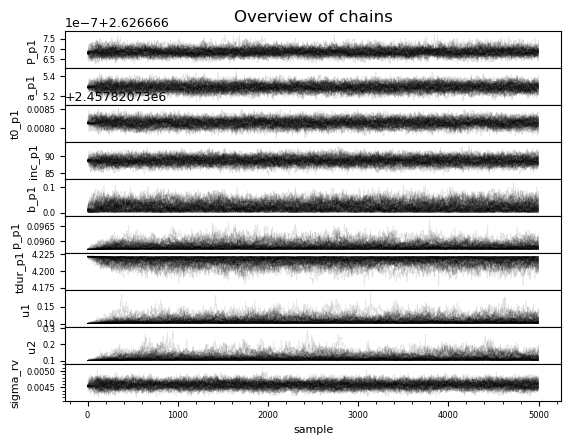

In [21]:
#We import mcmc_help.
import mcmc_help

#We use the plot_chains function to plot the chains as follows.
mcmc_help.plot_chains(TF.sampler.chain,labels=TF.lpf.ps_vary.labels)

plt.show();

In [22]:
#We define the burn in index to be 1000.
#This means that the first 1000 samples per chain will be ignored.
burnin_index = 1000

#We extract the chains after the burn in phase.
    #First part: We take all the chains.
    #Second part: We ignore the first 1000 samples per chain. (hence "burnin_index")
    #Third part: We take all the parameters.
chains_after_burnin = TF.sampler.chain[:,burnin_index:,:]

#We then flatten the chains as follows.
flatchain = chains_after_burnin.reshape((-1,len(TF.lpf.ps_vary.priors)))

#To store the posteriors we have obtained from the chains, we define a Pandas DataFrame as follows.
df_post = pd.DataFrame(flatchain,columns=TF.lpf.ps_vary.labels)

df_post

P_p1      a_p1         t0_p1     inc_p1      b_p1      p_p1  \
0       2.626667  5.314004  2.457821e+06  86.631721  0.016739  0.095759   
1       2.626667  5.311223  2.457821e+06  86.904991  0.016232  0.095755   
2       2.626667  5.311223  2.457821e+06  86.904991  0.016232  0.095755   
3       2.626667  5.311223  2.457821e+06  86.904991  0.016232  0.095755   
4       2.626667  5.311223  2.457821e+06  86.904991  0.016232  0.095755   
...          ...       ...           ...        ...       ...       ...   
399995  2.626667  5.298488  2.457821e+06  88.062937  0.032753  0.095763   
399996  2.626667  5.296543  2.457821e+06  87.983539  0.030238  0.095755   
399997  2.626667  5.296543  2.457821e+06  87.983539  0.030238  0.095755   
399998  2.626667  5.296543  2.457821e+06  87.983539  0.030238  0.095755   
399999  2.626667  5.292685  2.457821e+06  88.031992  0.024248  0.095749   

         tdur_p1        u1        u2  sigma_rv  
0       4.205196  0.102122  0.109406  0.004602  
1       4.206687  0.104691  0.108843  0.004600  
2       4.206687  0.104691  0.108843  0.004600  
3       4.206687  0.104691  0.108843  0.004600  
4       4.206687  0.104691  0.108843  0.004600  
...          ...       ...       ...       ...  
399995  4.211355  0.114180  0.120978  0.004490  
399996  4.209266  0.115188  0.122919  0.004470  
399997  4.209266  0.115188  0.122919  0.004470  
399998  4.209266  0.115188  0.122919  0.004470  
399999  4.210444  0.114454  0.128254  0.004500  

[400000 rows x 10 columns]

In [23]:
#We print out the median values as follows.
df_medvals = TF.get_mean_values_mcmc_posteriors(df_post.values)
df_medvals[['Labels','values']]

Labels                                     values
0      P_p1  $2.626666686_{-0.00000001}^{+0.00000001}$
0      a_p1                   $5.29_{-0.032}^{+0.033}$
0     t0_p1     $2457820.738133_{-0.00009}^{+0.00009}$
0    inc_p1                      $88.7_{-0.99}^{+1.0}$
0      b_p1                  $0.019_{-0.013}^{+0.019}$
0      p_p1           $0.095785_{-0.00006}^{+0.00012}$
0   tdur_p1               $4.2171_{-0.0062}^{+0.0033}$
0        u1               $0.1055_{-0.0041}^{+0.0090}$
0        u2                $0.1111_{-0.0082}^{+0.018}$
0  sigma_rv           $0.004577_{-0.00009}^{+0.00009}$

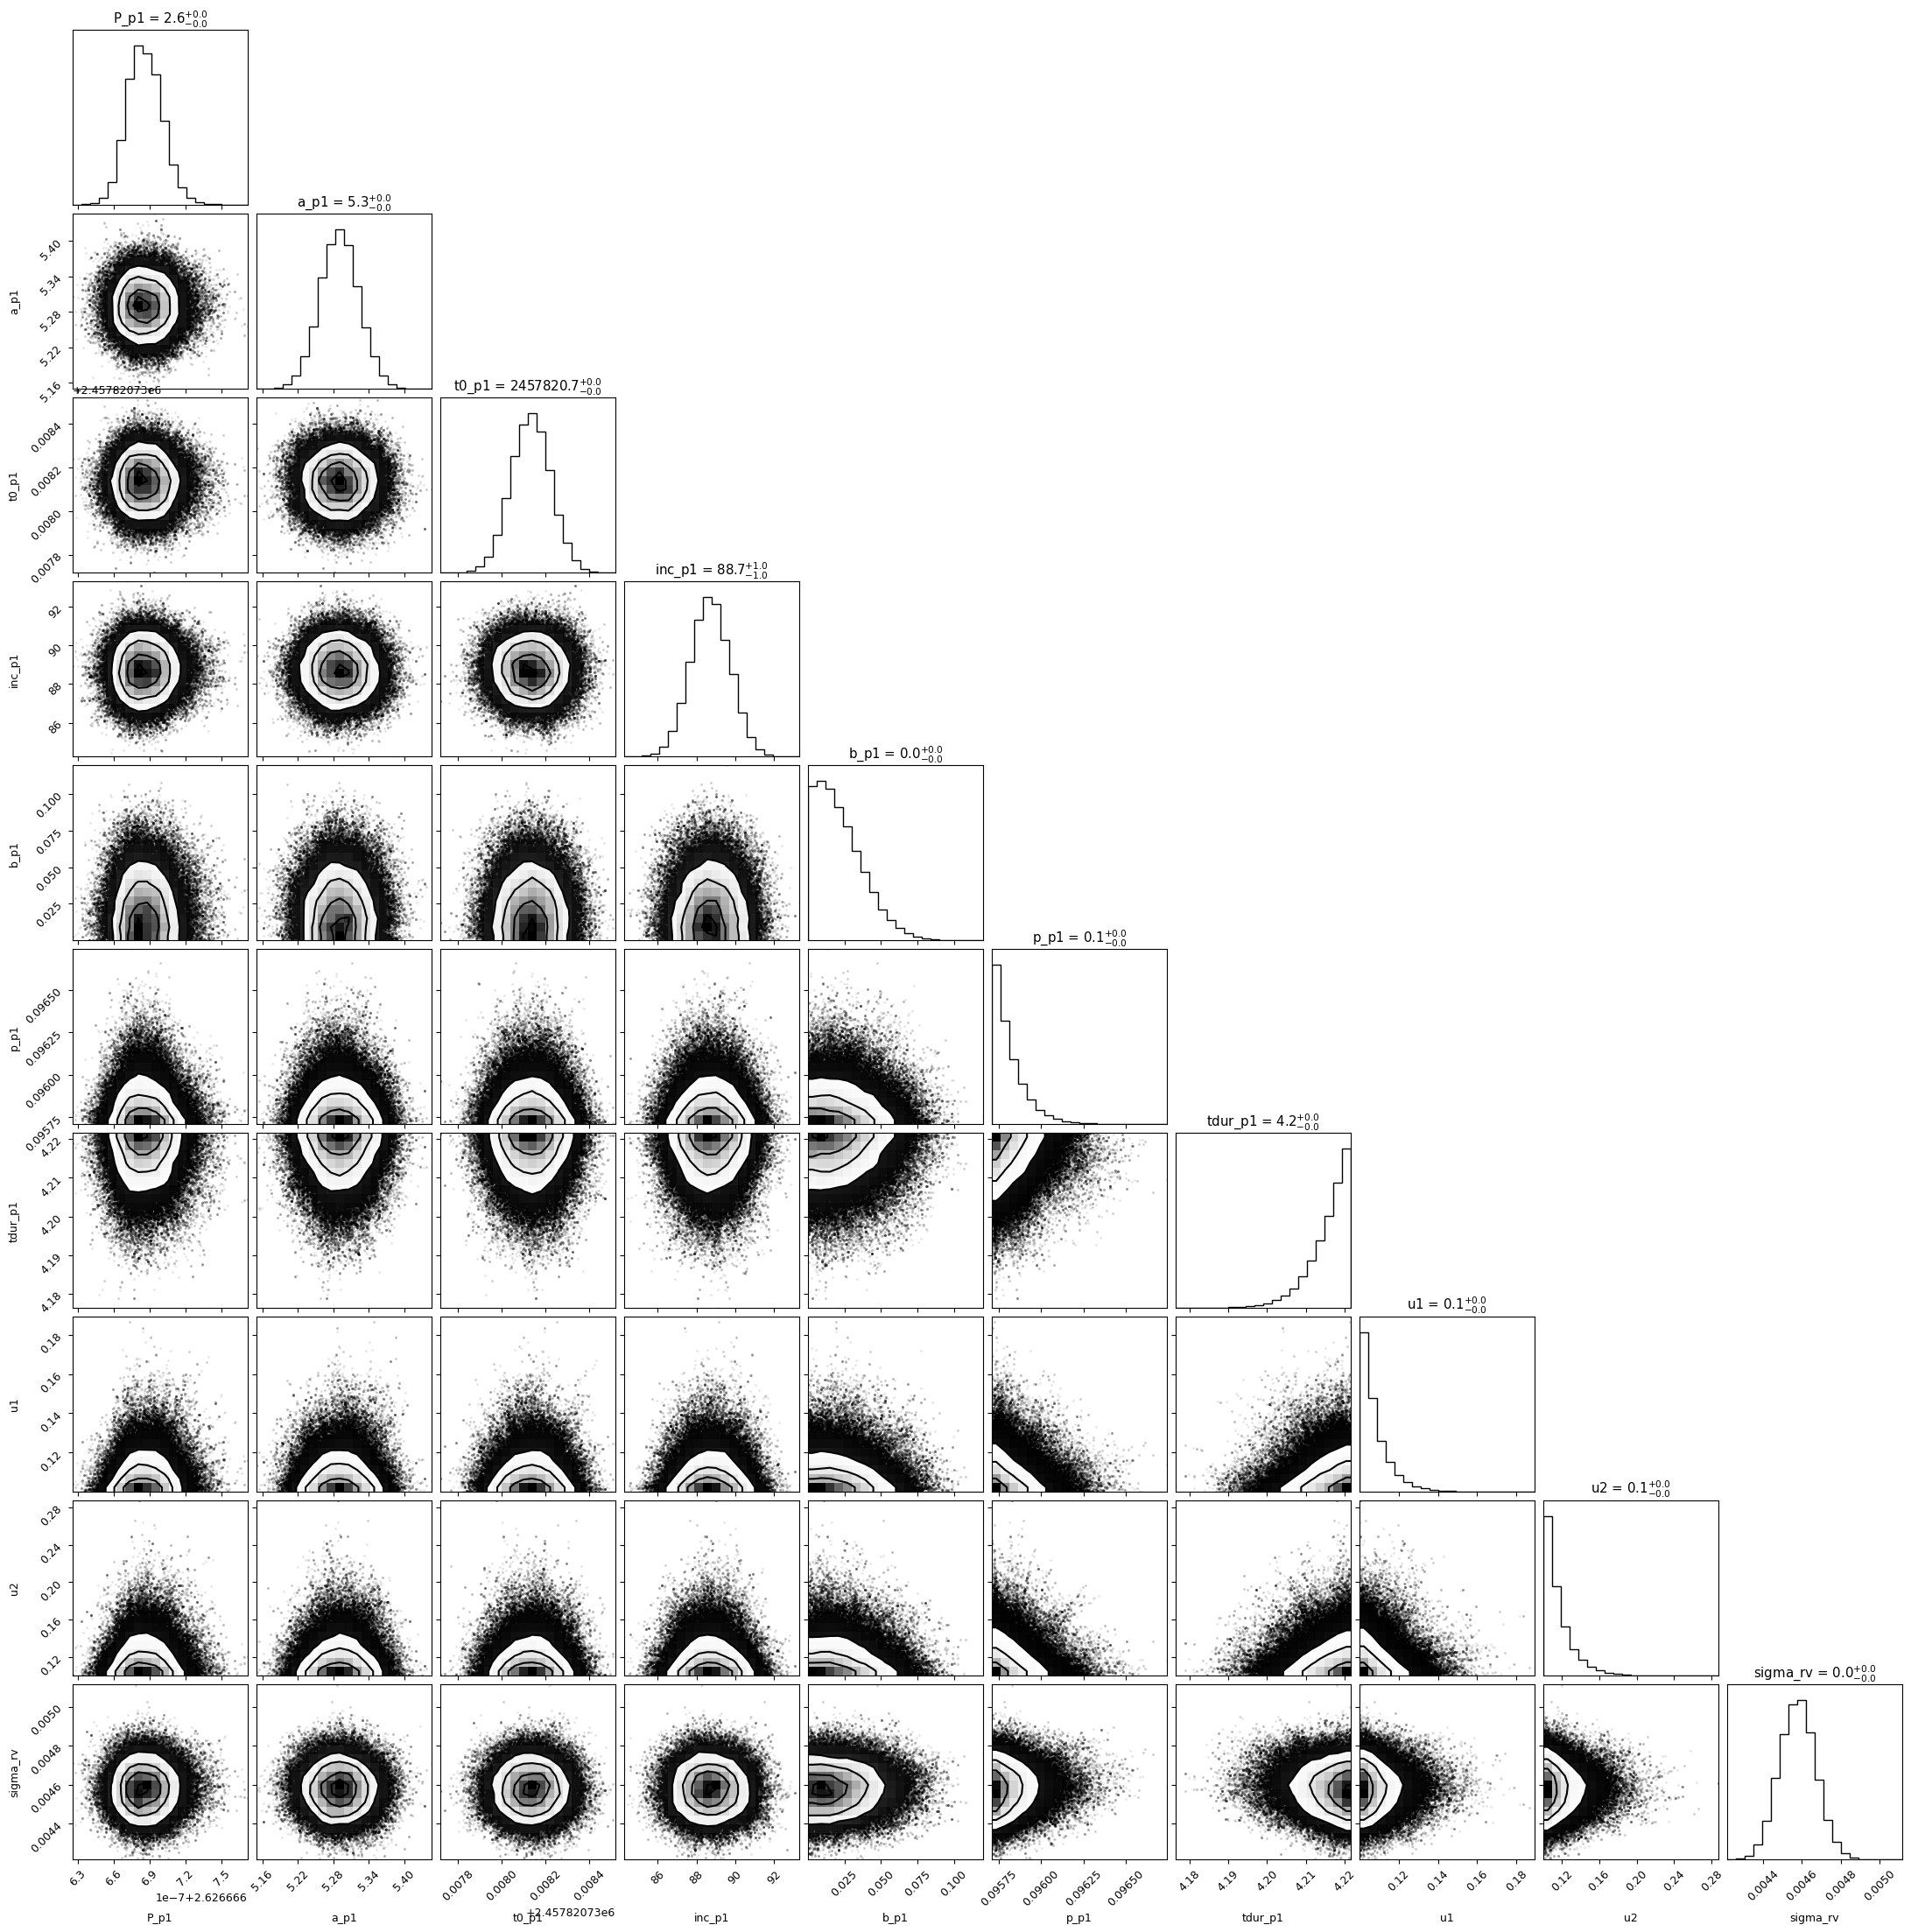

In [24]:
#We then plot the Corner Plot.
import corner
corner.corner(df_post.values,
       show_titles=True,labels=list(df_post.columns),title_fmt='.1f',xlabcord=(0.5, -0.2));

plt.show();

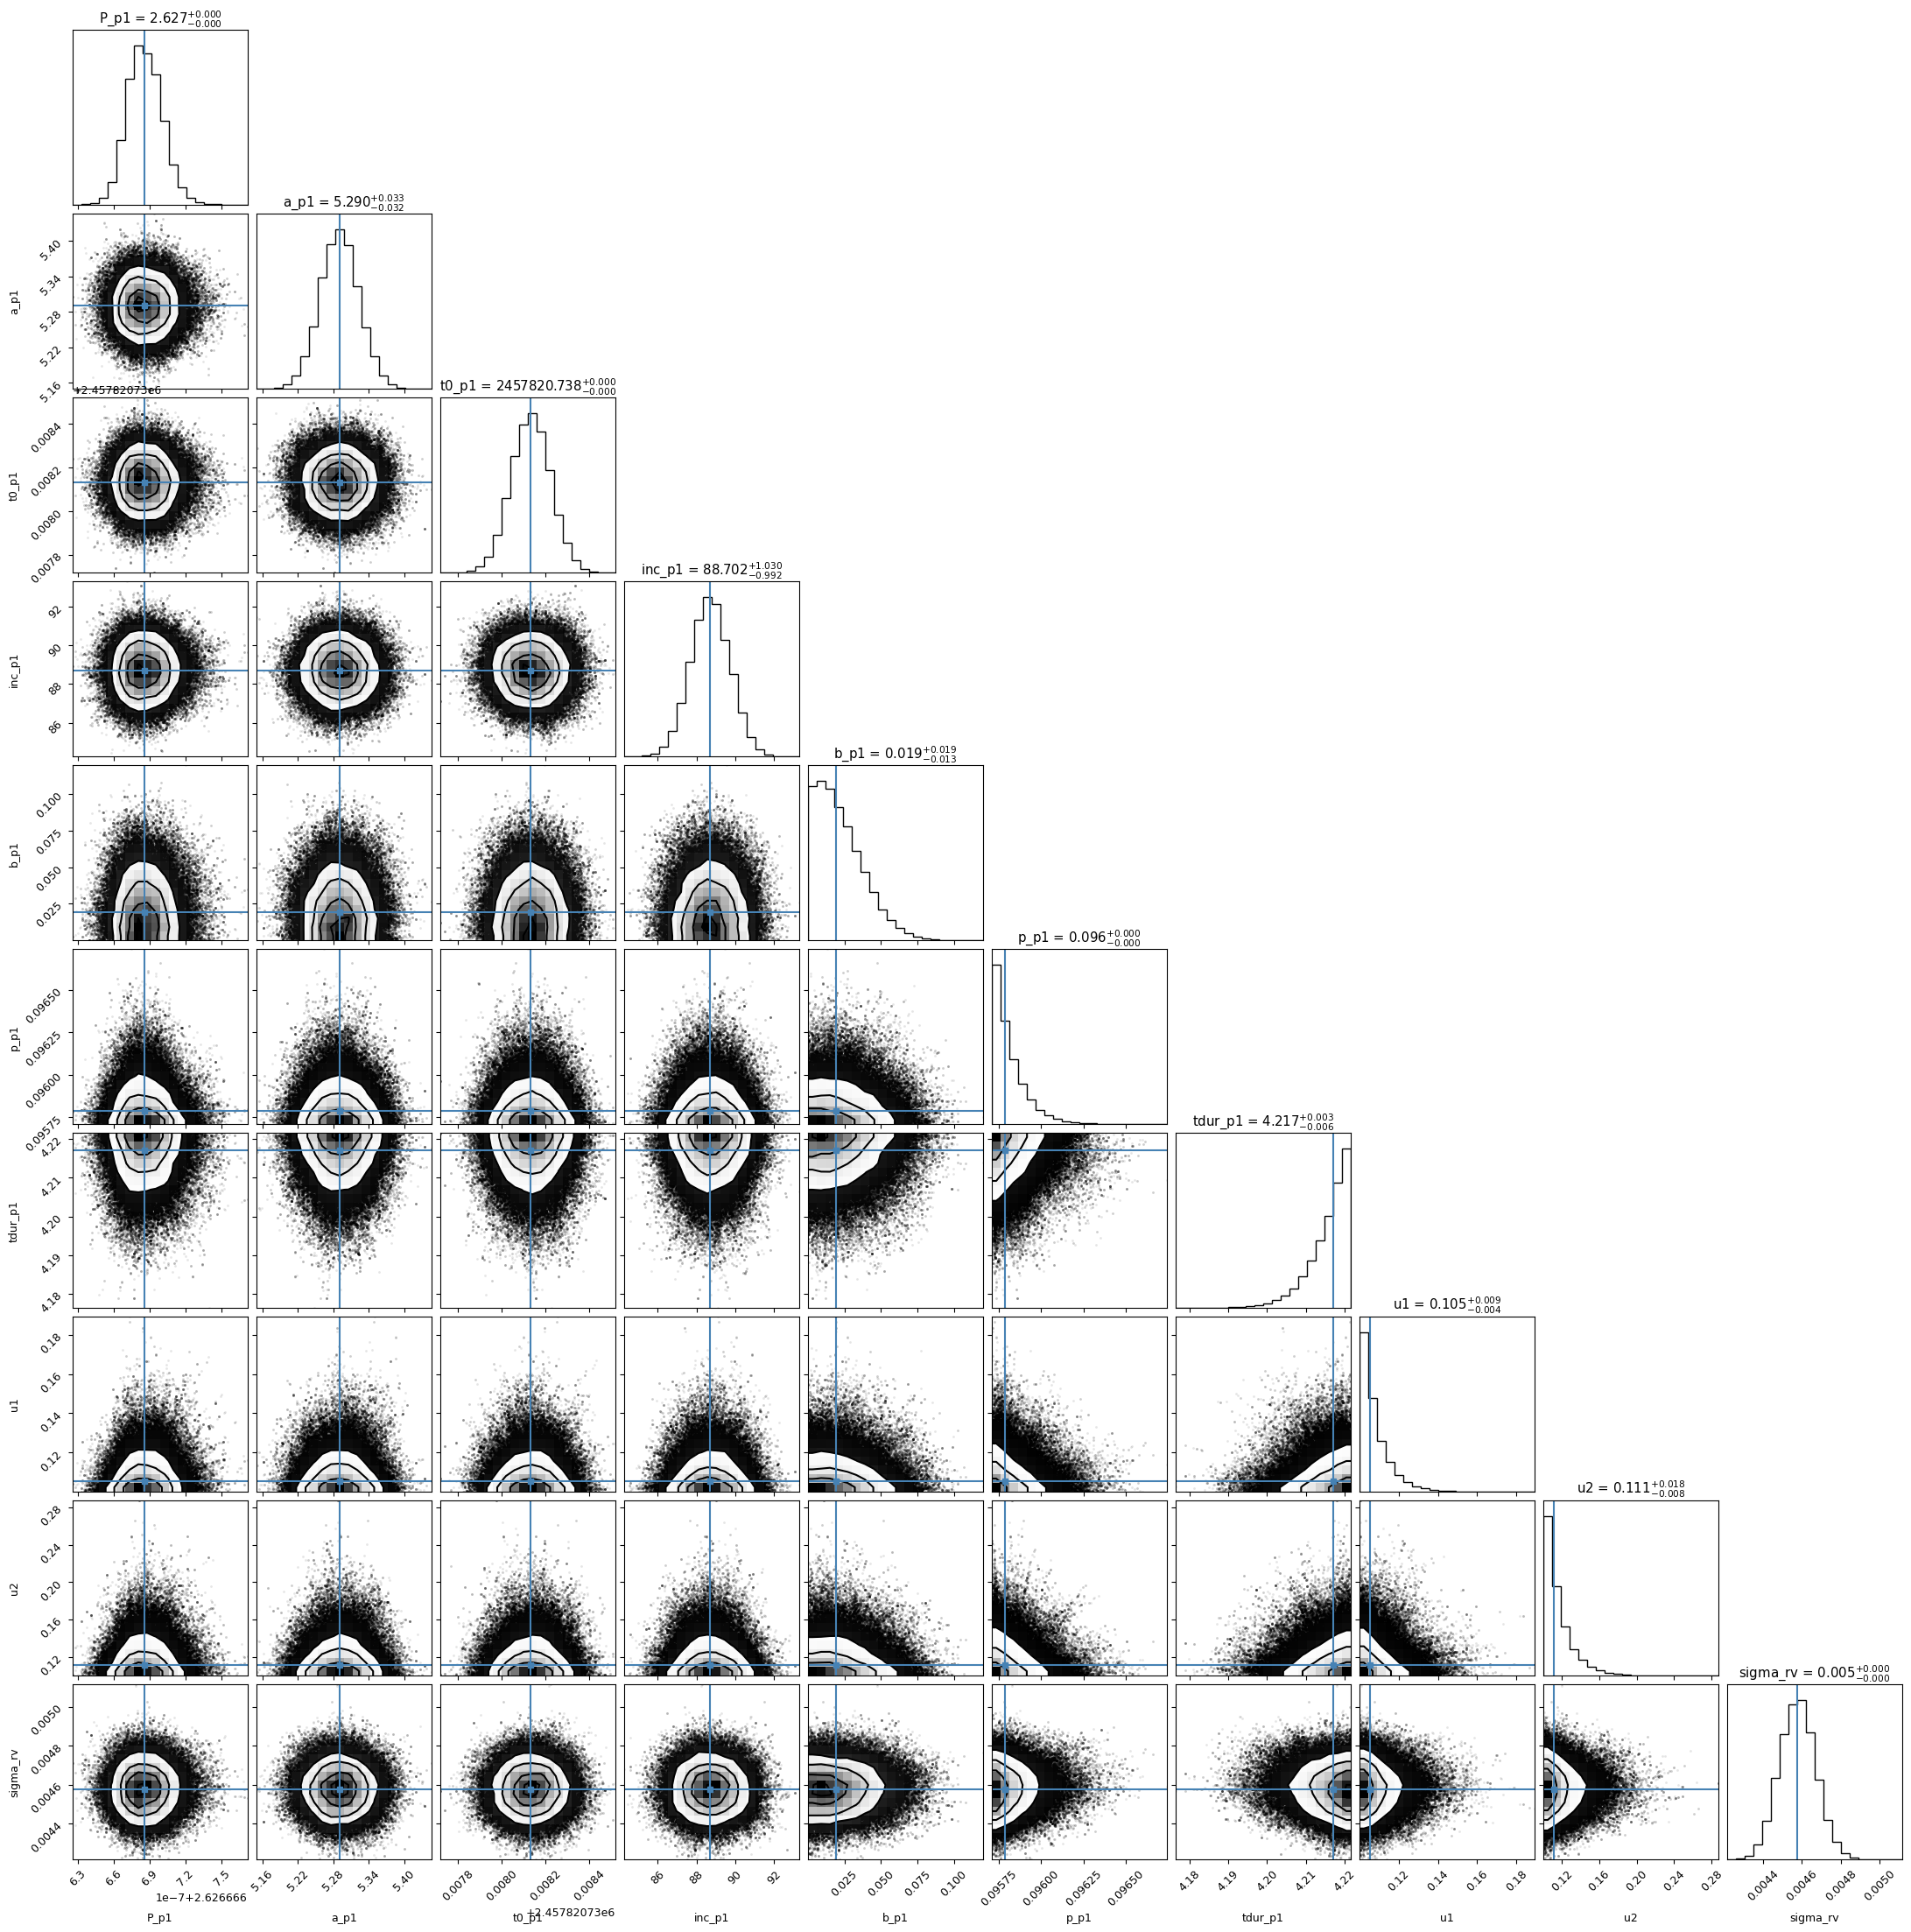

In [25]:
#We again plot the Corner plot but this time with the Truths included to compare them with the values we have obtained from MCMC.
import corner
pv_50 = np.percentile(flatchain,[50],axis=0)[0]
corner.corner(df_post.values,truths=pv_50,
       show_titles=True,labels=list(df_post.columns),title_fmt='.3f',xlabcord=(0.5, -0.2));

plt.show();

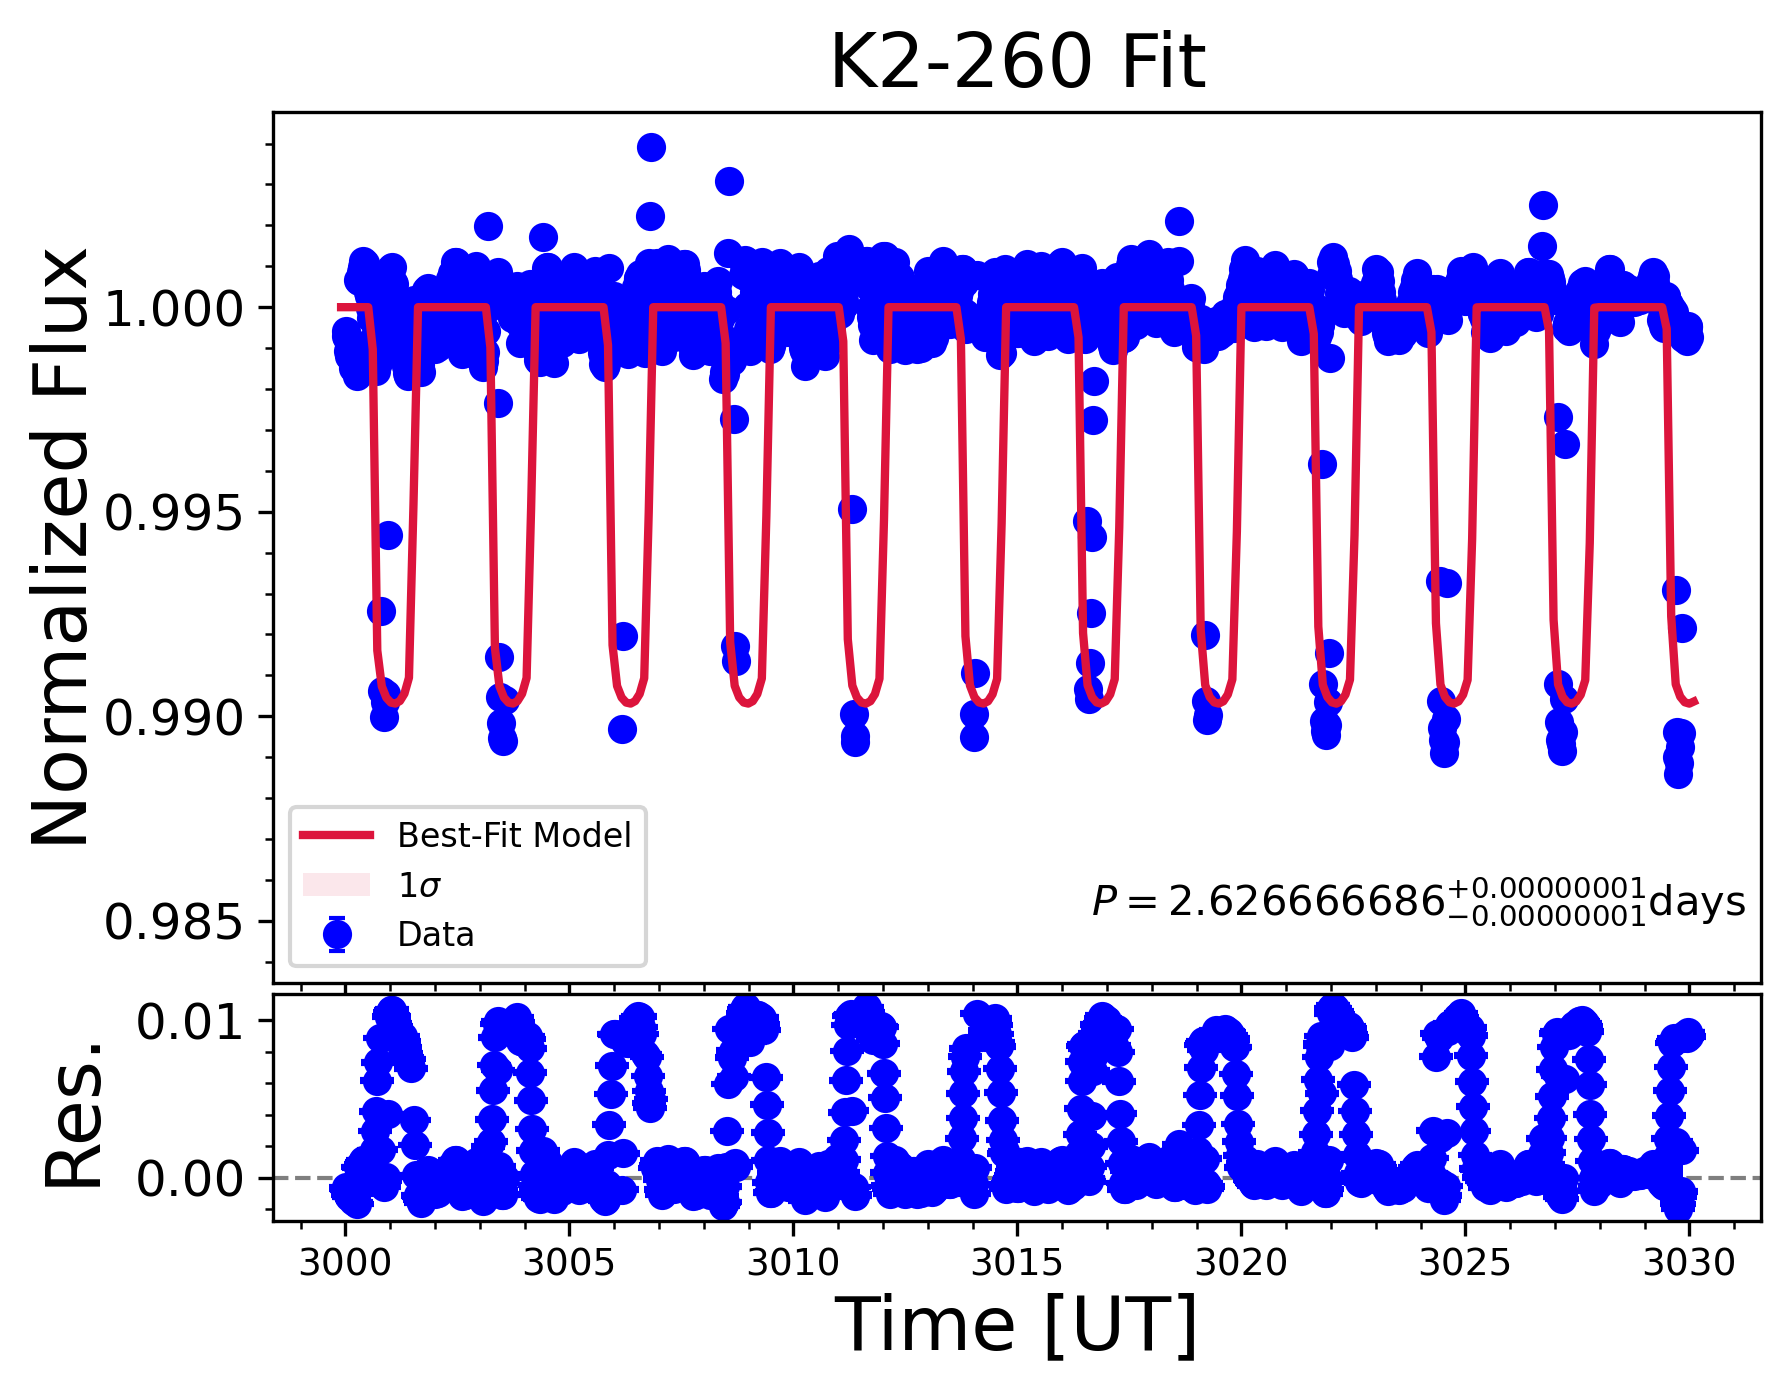

In [26]:
#We import astropy.time to convert Julian Dates into Datetimes i.e. the DD-MM-YYYY Format.
import astropy.time

#We define a function that turns Julian Dates into Datetime format.
def jd2datetime(times):
    return times
    #return np.array([astropy.time.Time(time,format="jd",scale="utc").datetime for time in times])

#We define the Title, Number of Models and the Shade color.
TITLE = 'K2-260 Fit'
NUMMODELS = 5000
shadecolor="black"

###################
#We define the times using the JD Times from the first and second dataset.
#Note that we define 500 time points.
times1 = np.linspace(TF.lpf.data['x'][0]-0.05,TF.lpf.data['x'][-1]+0.05,500)

#We define the 50th Percentile i.e. the Median by using the Flatchain we defined.
#The "[0]" is to get the percentiles out of the array and turn it into a list.
pv_50 = np.percentile(flatchain,[50],axis=0)[0]

#We define times for the model/fit this time, using the minimum and maximum times.
#Note that we define 300 time points for the fit.
t1_mod = np.linspace(times1.min()-0.05,times1.max()+0.05,300)

#Our goal is to get the Residuals i.e. Data - Model.
#For that first we compute the Radial Velocities for both instruments using 50th percentiles i.e. the Model.
rv_501 = TF.lpf.compute_total_model(pv_50,t1_mod)

#Then we get the Radial Velocities for both instruments using the datafiles we have i.e. Data.
rv_50_obs1 = TF.lpf.compute_total_model(pv_50,TF.lpf.data['x'])

#We calculate the residuals.
res1 = TF.lpf.data['y'] - rv_50_obs1

#We define the Figure and the Axes.
#Note that we have two rows with one of them showing the RV and the other one showing the Residuals.
fig, (ax,bx) = plt.subplots(dpi=300,nrows=2,gridspec_kw={'height_ratios': [5,1.3]},sharex=True)

#################
# Plot data
#################
#We first plot the Best-Fit Model.
#For that we first define a label.
label = r'Best-Fit Model'

#Then we also add the values of Period and Eccentricity into our label.
#Note that we are using "df_medvals" we found after MCMC.
#Note that we can also add Planet Mass and Inclination by removing "#" from the lines below.
lab = '$P=${}'.format(df_medvals[df_medvals.Labels=='P_p1']['values'].values[0])+'days\n'
#lab += r'$M_p=${}$M_E$'.format(earth_mass)+'\n'
#lab += r'$e=${}'.format(df_medvals[df_medvals.Labels=='ecc_p1']['values'].values[0])+'\n'
#lab += r'$K=${}$m/s$'.format(df_medvals[df_medvals.Labels=='K_p1']['values'].values[0])+'\n'

#We define the marker color to be black for errorbars.
markercolor="blue"

#We define the errorbars & datapoints.
#Note that we put times into the jd2datetime function so that the dates turn from JD to Datetime.
ax.errorbar(jd2datetime(TF.lpf.data['x']),TF.lpf.data['y'],TF.lpf.data['error'],
            marker='o',elinewidth=1,capsize=2,lw=0,mew=1,color=markercolor,markersize=6,label='Data')

#We finally also plot our model as follows.
ax.plot(jd2datetime(t1_mod),rv_501,color="crimson",label=label,lw=2.,zorder=10)

#Now we work on the second Row for the Resiudal graph.
#We also need to plot the residuals with the error bars included.

#For that we define the errorbars & datapoints for the first dataset from first instrument.
bx.errorbar(jd2datetime(TF.lpf.data['x']),res1,TF.lpf.data['error'],
            marker='o',elinewidth=1,capsize=4,lw=0,mew=1,color=markercolor,markersize=6)

#We add the values of our Parameters to the Bottom-Right of our first Graph i.e. RV Graph.
ax.text(0.99,0.01,lab,va='bottom',ha='right',fontsize=10,transform=ax.transAxes)

#We define a list to sample from our model, which we will use for Sigma Errors of our Fit.
mmodel1 = []
for i in range(NUMMODELS):
    #if i%100 == 0: print("Sampling, i=",i)
    idx = np.random.randint(0, flatchain.shape[0])
    m1 = TF.lpf.compute_total_model(flatchain[idx],times=t1_mod)
    mmodel1.append(m1)
mmodel1 = np.array(mmodel1)

#We then show the 1-Sigma Error of our fit as follows.
#There are also options for 2-Sigma and 3-Sigma Errors, commented below.
ax.fill_between(jd2datetime(t1_mod),np.quantile(mmodel1,0.16,axis=0),np.quantile(mmodel1,0.84,axis=0),
                alpha=0.1,color='crimson',lw=0,label='1$\sigma$',zorder=-1)

#We show define the legend for the first row i.e. the RV Graph.
ax.legend(loc='lower left',fontsize=8)

#We define the x-axis and y-axis labels for the second row i.e. the Residuals Graph.
bx.set_xlabel('Time [UT]',labelpad=2,fontsize=18)
bx.set_ylabel('Res.',labelpad=6,fontsize=18)

#We also define the x-axis of the first row i.e. the RV Graph.
ax.set_ylabel('Normalized Flux',labelpad=0,fontsize=18)

#We then define the x limit by using ax.get_xlim()
xlim = ax.get_xlim()

#Using the x limits we define the new xlim to be the first and second element of the xlim array.
ax.set_xlim(xlim[0],xlim[-1])

#We define extra times to plot the zero-line for Residuals.
_x = np.linspace(xlim[0],xlim[-1],100)

#We use the extra times we defined to plot the zero-line for residuals.
bx.plot(_x,0*np.ones(100),color='black',ls='--',lw=1,alpha=0.5,zorder=-10)

#We then set a 0.02 horizontal space between the rows. (Tighter than the default setup.)
fig.subplots_adjust(hspace=0.02)

for xx in [ax,bx]:
    utils.ax_apply_settings(xx)
    xx.grid(lw=0)

bx.tick_params(axis='x',labelsize=9)
ax.set_title(TITLE,fontsize=18)#,y=1.05)

ylim = ax.get_ylim()
ax.set_ylim(ylim[0]-(ylim[-1]-ylim[0])/4, ylim[-1])

#plt.savefig("toi_2431.png", dpi = 500)
plt.show();

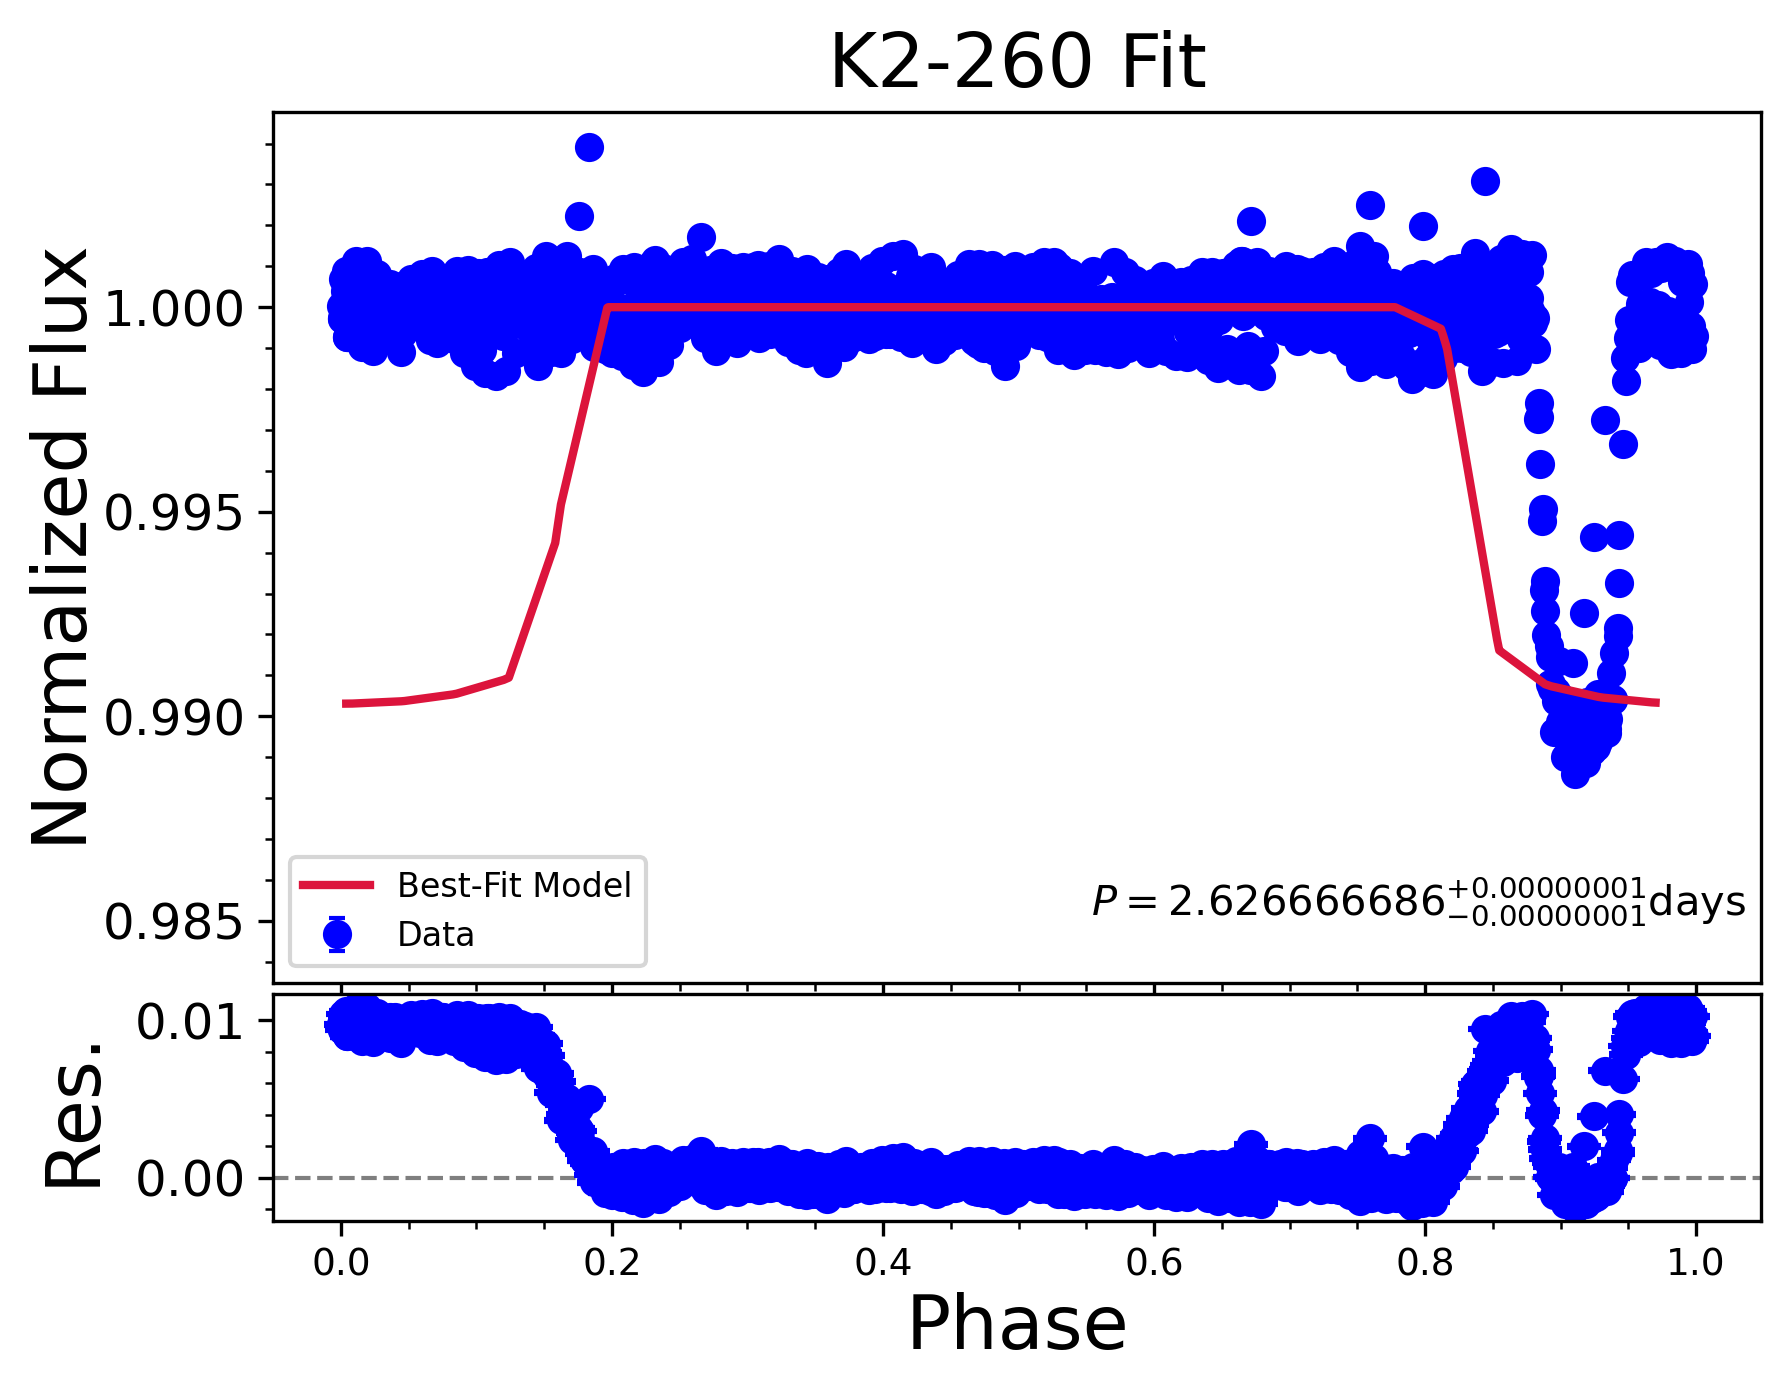

In [27]:
#We get the P and T0 values from the MCMC results.
P = df_medvals["medvals"][df_medvals["Labels"] == "P_p1"].values[0]
T_0 = df_medvals["medvals"][df_medvals["Labels"] == "t0_p1"].values[0]

#We then define a function to convert observation times to the Orbital Phase.
def time_to_phase(times, P, T_0):
    """Takes the Observation Times, Period and the T0. Returns the orbital 
    phases for given Observation Times.
    
    Input:
    ----------------------------------------------------------------------------
    times: Array of observation times (Julian Dates)
    P: Orbital period in days
    T_0: Reference time (epoch or time of periastron) in Julian Date
    
    Output:
    ----------------------------------------------------------------------------
    ((times - T_0) % P) / P: Orbital Phases
    
    """
    
    #Normalize time to phase in the range [0, 1]
    return ((times - T_0) % P) / P

#We convert the observation times from our data to the orbital phases.
phase1 = time_to_phase(TF.lpf.data['x'], P, T_0)

#We also convert the times for the model/fit to the orbital phases.
phase_model = time_to_phase(t1_mod, P, T_0)

#Now we define a figure again for our Phase Curve & Residuals.
fig, (ax, bx) = plt.subplots(dpi=300, nrows=2, gridspec_kw={'height_ratios': [5, 1.3]}, sharex=True)

#################
# Plot data
#################

#We first sort our data according to the Phase values we have.
sorted_indices = np.argsort(phase_model)
phase_model_sorted = phase_model[sorted_indices]
rv_501_sorted = rv_501[sorted_indices]

#Then we plot the fit as follows.
label = r'Best-Fit Model'
ax.plot(phase_model_sorted, rv_501_sorted, color="crimson", label=label, lw=2., zorder=10)

#We then plot our data around the fit as follows.
ax.errorbar(phase1, TF.lpf.data['y'], TF.lpf.data['error'],
            marker='o', elinewidth=1, capsize=2, lw=0, mew=1, color=markercolor, markersize=6, label='Data')

#We plot the residuals on the second row as follows.
res1 = TF.lpf.data['y'] - rv_50_obs1
bx.errorbar(phase1, res1, TF.lpf.data['error'],
            marker='o', elinewidth=1, capsize=4, lw=0, mew=1, color=markercolor, markersize=6)

#We add the label for the fit parameters
ax.text(0.99, 0.01, lab, va='bottom', ha='right', fontsize=10, transform=ax.transAxes)

# For plotting the sigma errors (1-sigma range) - Does not work.
# mmodel1 = []
# for i in range(NUMMODELS):
#     idx = np.random.randint(0, flatchain.shape[0])
#     m1 = TF.lpf.compute_total_model(flatchain[idx], times=t1_mod)
#     mmodel1.append(m1)
# mmodel1 = np.array(mmodel1)

# # Plot 1-sigma error range
# ax.fill_between(phase_model, np.quantile(mmodel1, 0.16, axis=0), np.quantile(mmodel1, 0.84, axis=0),
#                 alpha=0.1, color='crimson', lw=0, label='1$\sigma$', zorder=-1)

#We add the legend and the labels.
ax.legend(loc='lower left', fontsize=8)

#We show define the legend for the first row i.e. the RV Graph.
ax.legend(loc='lower left',fontsize=8)

#We define the x-axis and y-axis labels for the second row i.e. the Residuals Graph.
bx.set_xlabel('Phase',labelpad=2,fontsize=18)
bx.set_ylabel('Res.',labelpad=6,fontsize=18)

#We also define the x-axis of the first row i.e. the RV Graph.
ax.set_ylabel('Normalized Flux',labelpad=0,fontsize=18)

#We then define the x limit by using ax.get_xlim()
xlim = ax.get_xlim()

#Using the x limits we define the new xlim to be the first and second element of the xlim array.
ax.set_xlim(xlim[0],xlim[1])
ax.set_ylim()

#We define extra times to plot the zero-line for Residuals.
_x = np.linspace(xlim[0],xlim[-1],100)

#We use the extra times we defined to plot the zero-line for residuals.
bx.plot(_x,0*np.ones(100),color='black',ls='--',lw=1,alpha=0.5,zorder=-10)

#We then set a 0.02 horizontal space between the rows. (Tighter than the default setup.)
fig.subplots_adjust(hspace=0.02)

for xx in [ax,bx]:
    utils.ax_apply_settings(xx)
    xx.grid(lw=0)

bx.tick_params(axis='x',labelsize=9)
ax.set_title(TITLE,fontsize=18)#,y=1.05)

ylim = ax.get_ylim()
ax.set_ylim(ylim[0]-(ylim[-1]-ylim[0])/4, ylim[-1])

plt.show();